#### This demo only demonstrates how to use evaluation module, so will be very simple and rough on feature ETL, feature engineer, preprocessing steps

## Part1. Fetching the dataset

In [1]:
from CommonTools.login import get_credential
from CommonTools.settings import SETTINGS
from CommonTools.remote import MyRemote

import pandas as pd
import numpy as np
import logging

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)
SETTINGS.SET_CREDENTIAL_INTERACTIVE()  # set to interactive mode

In [2]:
username, PASSWORD = get_credential()

Your SID:  ········
Your password:  ·············


In [3]:
# connect to iw607 is pretty straight forward, as it only need ip, port, username and password
ip_iw607, port = "10.56.70.52", 22
iw607 = MyRemote(ip_iw607, port, username, PASSWORD)

In [4]:
with iw607.getFileHandler("/rcca/ProdEcon/AQ/demo-loan-default/Loan_Default.csv", mode = "r") as obj:
    df = pd.read_csv(obj)
    
# only keep a few columns for simplicity and for demonstration purpose only
columns = ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'loan_amount', 'Credit_Score', 'income', 'LTV', 'Status']
df = df[columns]
df

loan_limit approv_in_adv loan_type loan_purpose Credit_Worthiness  \
0              cf         nopre     type1           p1                l1   
1              cf         nopre     type2           p1                l1   
2              cf           pre     type1           p1                l1   
3              cf         nopre     type1           p4                l1   
4              cf           pre     type1           p1                l1   
...           ...           ...       ...          ...               ...   
148665         cf         nopre     type1           p3                l1   
148666         cf         nopre     type1           p1                l1   
148667         cf         nopre     type1           p4                l1   
148668         cf         nopre     type1           p4                l1   
148669         cf         nopre     type1           p3                l1   

        loan_amount  Credit_Score   income        LTV  Status  
0            116500           758   1740.0  98.728814       1  
1            206500           552   4980.0        NaN       1  
2            406500           834   9480.0  80.019685       0  
3            456500           587  11880.0  69.376900       0  
4            696500           602  10440.0  91.886544       0  
...             ...           ...      ...        ...     ...  
148665       436500           659   7860.0  71.792763       0  
148666       586500           569   7140.0  74.428934       0  
148667       446500           702   6900.0  61.332418       0  
148668       196500           737   7140.0  70.683453       0  
148669       406500           830   7260.0  72.849462       0  

[148670 rows x 10 columns]

In [5]:
# split the data into training and testing set using stratified sampling
from sklearn.model_selection import train_test_split

X = df[['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'loan_amount', 'Credit_Score', 'income', 'LTV']]
y = df['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

## Part2. ETL, preprocessing and feature selection pipeline (simplified)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from ModelingTools.utils.support import make_present_col_selector

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer

#### feature preprocessing pipeline

In [7]:
categ_preprocess_pipe = Pipeline(steps = [
    ('mode_impute', SimpleImputer(strategy = 'most_frequent', add_indicator = True)),  # add indicator column for missing value
    ('ohe', OneHotEncoder(drop = 'if_binary'))
])

num_preprocess = ColumnTransformer(
    transformers = [
        (
            'log_num', 
            Pipeline([
                ('median_impute', SimpleImputer(strategy = 'median', add_indicator = True)),   # add indicator column for missing value
                ('log', FunctionTransformer(func = np.log1p, inverse_func = np.expm1, validate = True, accept_sparse = True)),  # log transformation using sklearn function transformer
                ('scaler', StandardScaler())
            ]),
            make_present_col_selector(['loan_amount', 'income'])
        ),
        (
            'regular_num', 
            Pipeline([
                ('median_impute', SimpleImputer(strategy = 'median', add_indicator = True)),   # add indicator column for missing value
                ('scaler', RobustScaler())
            ]),
            make_present_col_selector(['Credit_Score', 'LTV'])
        ),
    ],
    remainder = 'passthrough'
)

# combine two transformer pipelines
preprocess_pipe = ColumnTransformer(
    transformers = [
        ('categ', categ_preprocess_pipe,  make_present_col_selector(['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness'])),
        ('numeric', num_preprocess,  make_present_col_selector(['loan_amount', 'Credit_Score', 'income', 'LTV']))
    ]
)
preprocess_pipe

ColumnTransformer(transformers=[('categ',
                                 Pipeline(steps=[('mode_impute',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 functools.partial(<function _select_present_subset at 0x7fab951964c0>, ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness'])),
                                ('numeric',
                                 ColumnTransformer(...
                                                                  functools.partial(<function _select_present_subset at 0x7fab951964c0>, ['loan_amount', 'income'])),
                                                                 ('regular_num',
                                                                  Pipeline(steps=[('median_impute',
                                                                                   SimpleImputer(add_indicator=True,
                                                                                                 strategy='median')),
                                                                                  ('scaler',
                                                                                   RobustScaler())]),
                                                                  functools.partial(<function _select_present_subset at 0x7fab951964c0>, ['Credit_Score', 'LTV']))]),
                                 functools.partial(<function _select_present_subset at 0x7fab951964c0>, ['loan_amount', 'Credit_Score', 'income', 'LTV']))])

#### feature selection pipeline

In [8]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import Lasso

# using recursive feature elimination technique, use L1 regression as the kernal selector, (L1 will shrink non-critical feature's coefficient to zero)
feature_sel = RFE(estimator = Lasso(alpha = 1.0), n_features_to_select = 0.7, verbose = 3)  # keep only 70% of the original features
feature_sel

RFE(estimator=Lasso(), n_features_to_select=0.7, verbose=3)

## Part3. Model training and hyperparameter tuning

In [9]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier # correct for imbalanced dataset
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [10]:
# model 1 uses decision tree classifier, and correct for imbalanced dataset (wrap with balanced bagging)
model1 = BalancedBaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 100,
    max_samples = 0.8,
    max_features = 1.0,
    n_jobs = -1
)

param_grid1 = {
    'max_features' : [1.0, 0.8],  # proportion of features selected for each bootstrap step of Bagging
    'base_estimator__max_depth' : [None, 6],        # max depth of decision tree
    'base_estimator__criterion' : ['gini', 'entropy']  # criteria of decision tree
}

pipe1 = Pipeline([
    ('preprocess', preprocess_pipe),  # preprocessing pipeline
    ('feature_sel', feature_sel),  # recursive feature elimination
    ('grid', GridSearchCV(
        estimator = model1,
        param_grid = param_grid1,
        scoring = ['balanced_accuracy', 'average_precision', 'roc_auc'],  # report three metrics
        refit = 'balanced_accuracy',  # use balanced accuracy as metric for best param choosing
        cv = StratifiedKFold(n_splits = 3),  # stratified sampling
        n_jobs = -1,
        verbose = 100
    ))
])
pipe1

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categ',
                                                  Pipeline(steps=[('mode_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  functools.partial(<function _select_present_subset at 0x7fab951964c0>, ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness']))...
                              estimator=BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                                                  max_samples=0.8,
                                                                  n_estimators=100,
                                                                  n_jobs=-1),
                              n_jobs=-1,
                              param_grid={'base_estimator__criterion': ['gini',
                                                                        'entropy'],
                                          'base_estimator__max_depth': [None,
                                                                        6],
                                          'max_features': [1.0, 0.8]},
                              refit='balanced_accuracy',
                              scoring=['balanced_accuracy', 'average_precision',
                                       'roc_auc'],
                              verbose=100))])

In [11]:
# model 2 uses pure decision tree classifier, dont correct for imbalanced dataset
model2 = DecisionTreeClassifier()

param_grid2 = {
    'max_depth' : [None, 6],        # max depth of decision tree
    'criterion' : ['gini', 'entropy']  # criteria of decision tree
}

pipe2 = Pipeline([
    ('preprocess', preprocess_pipe),  # preprocessing pipeline
    ('feature_sel', feature_sel),  # recursive feature elimination
    ('grid', GridSearchCV(
        estimator = model2,
        param_grid = param_grid2,
        scoring = ['balanced_accuracy', 'average_precision', 'roc_auc'],  # report three metrics
        refit = 'balanced_accuracy',  # use balanced accuracy as metric for best param choosing
        cv = StratifiedKFold(n_splits = 3),  # stratified sampling
        n_jobs = -1,
        verbose = 100
    ))
])
pipe2

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categ',
                                                  Pipeline(steps=[('mode_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  functools.partial(<function _select_present_subset at 0x7fab951964c0>, ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness']))...
                 RFE(estimator=Lasso(), n_features_to_select=0.7, verbose=3)),
                ('grid',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(), n_jobs=-1,
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [None, 6]},
                              refit='balanced_accuracy',
                              scoring=['balanced_accuracy', 'average_precision',
                                       'roc_auc'],
                              verbose=100))])

In [12]:
# model 3 uses pure logistic regression, dont correct for imbalanced dataset
model3 = LogisticRegression(solver = 'saga')

param_grid3 = {
    'C' : [0.5, 1.0, 1.5],        # C of logistic regression
    'penalty' : ['l1', 'l2']  # penalty of logistic regression
}

pipe3 = Pipeline([
    ('preprocess', preprocess_pipe),  # preprocessing pipeline
    ('feature_sel', feature_sel),  # recursive feature elimination
    ('grid', GridSearchCV(
        estimator = model3,
        param_grid = param_grid3,
        scoring = ['balanced_accuracy', 'average_precision', 'roc_auc'],  # report three metrics
        refit = 'balanced_accuracy',  # use balanced accuracy as metric for best param choosing
        cv = StratifiedKFold(n_splits = 3),  # stratified sampling
        n_jobs = -1,
        verbose = 100
    ))
])
pipe3

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categ',
                                                  Pipeline(steps=[('mode_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  functools.partial(<function _select_present_subset at 0x7fab951964c0>, ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness']))...
                 RFE(estimator=Lasso(), n_features_to_select=0.7, verbose=3)),
                ('grid',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                              estimator=LogisticRegression(solver='saga'),
                              n_jobs=-1,
                              param_grid={'C': [0.5, 1.0, 1.5],
                                          'penalty': ['l1', 'l2']},
                              refit='balanced_accuracy',
                              scoring=['balanced_accuracy', 'average_precision',
                                       'roc_auc'],
                              verbose=100))])

In [13]:
pipe1.fit(X_train, y_train)
pipe2.fit(X_train, y_train)
pipe3.fit(X_train, y_train)

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('categ',
                                                  Pipeline(steps=[('mode_impute',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  functools.partial(<function _select_present_subset at 0x7fab951964c0>, ['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness']))...
                 RFE(estimator=Lasso(), n_features_to_select=0.7, verbose=3)),
                ('grid',
                 GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                              estimator=LogisticRegression(solver='saga'),
                              n_jobs=-1,
                              param_grid={'C': [0.5, 1.0, 1.5],
                                          'penalty': ['l1', 'l2']},
                              refit='balanced_accuracy',
                              scoring=['balanced_accuracy', 'average_precision',
                                       'roc_auc'],
                              verbose=100))])

## Part4. evaluation on single regular classification model

In [14]:
from ModelingTools.Evaluation import ClfValidator

clv = ClfValidator(pipe1, X_test, y_test)

(Predicted      0     1
 Actual                
 0          25433  2575
 1           3577  5583,
 Predicted         0         1
 Actual                       
 0          0.000000  0.091938
 1          0.390502  0.000000)

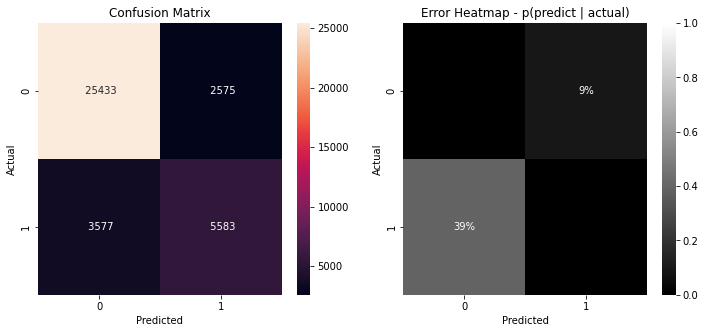

In [15]:
clv.confusion_matrix()

{0:      threshold       fpr       tpr
 0     2.000000  0.000000  0.000000
 1     1.000000  0.000000  0.000643
 2     0.990000  0.000109  0.001928
 3     0.981667  0.000109  0.001964
 4     0.980000  0.000764  0.005177
 ..         ...       ...       ...
 231   0.040000  0.553821  0.999750
 232   0.030000  0.557751  0.999786
 233   0.020000  0.562227  0.999821
 234   0.010000  0.569105  0.999857
 235   0.000000  1.000000  1.000000
 
 [236 rows x 3 columns],
 1:      threshold       fpr       tpr
 0     2.000000  0.000000  0.000000
 1     1.000000  0.000143  0.430895
 2     0.990000  0.000179  0.437773
 3     0.980000  0.000214  0.442249
 4     0.970000  0.000250  0.446179
 ..         ...       ...       ...
 231   0.030000  0.994823  0.999236
 232   0.020000  0.998036  0.999891
 233   0.018333  0.998072  0.999891
 234   0.010000  0.999357  1.000000
 235   0.000000  1.000000  1.000000
 
 [236 rows x 3 columns],
 'AVG':      threshold       fpr       tpr
 0          NaN  0.000000  0.0003

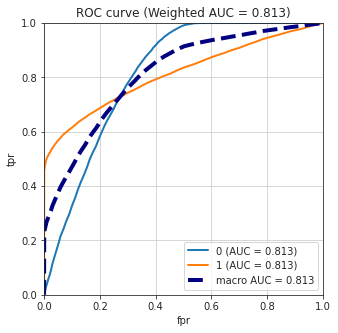

In [16]:
clv.roc_curve()

In [17]:
clv.precision_recall()

{0:      threshold  precision    recall
 0     0.000000   0.753551  1.000000
 1     0.010000   0.843062  0.999857
 2     0.020000   0.844660  0.999821
 3     0.030000   0.845701  0.999786
 4     0.040000   0.846617  0.999750
 ..         ...        ...       ...
 230   0.970000   0.921569  0.010069
 231   0.980000   0.953947  0.005177
 232   0.981667   0.982143  0.001964
 233   0.990000   0.981818  0.001928
 234   1.000000   1.000000  0.000643
 
 [235 rows x 3 columns],
 1:      threshold  precision    recall
 0     0.000000   0.246449  1.000000
 1     0.010000   0.246568  1.000000
 2     0.018333   0.246787  0.999891
 3     0.020000   0.246793  0.999891
 4     0.030000   0.247271  0.999236
 ..         ...        ...       ...
 230   0.960000   0.998057  0.448581
 231   0.970000   0.998290  0.446179
 232   0.980000   0.998521  0.442249
 233   0.990000   0.998755  0.437773
 234   1.000000   0.998988  0.430895
 
 [235 rows x 3 columns],
 'AVG':      threshold  precision    recall
 0      

## Part5. model performance comparison accross different classification models

In [19]:
from ModelingTools.Evaluation import ClfModelSelector

clf_dict = {'Balanced DT' : pipe1, 'DT' : pipe2, 'LR' : pipe3}
clfms = ClfModelSelector(clf_dict, X_test, y_test)

In [21]:
rocs = clfms.roc_curve(average = 'macro')

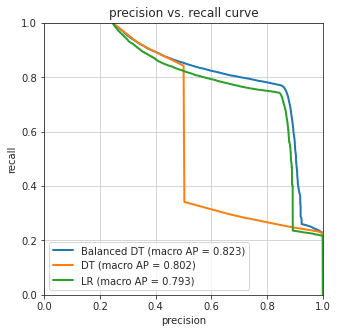

In [22]:
pre_recs = clfms.precision_recall(average = 'macro')

## Part6. model validation and comparison with ordinal classification model